# Credits

This is heavily influenced from https://github.com/pytorch/tutorials

# CIFAR-10

In thins notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.
The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


In order to train a classifier the following steps needs to be performed:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

We will help you along the way.
We indicate the places you need to modify the code with `# Your code here!`.
It is however a good idea to read the entire assignment before you begin coding!

## 1. Loading and normalizing CIFAR10

Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]

**NB** Modify the code below to only use a small part of the dataset if your computer is very slow.

In [112]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

used_categories = range(len(classes))

## USE CODE BELOW IF YOUR COMPUTER IS TOO SLOW
reduce_dataset = True
if reduce_dataset:
    used_categories = (3, 5) # cats and dogs

    classes = [classes[i] for i in used_categories]
    new_train_data = []
    new_train_labels = []

    new_test_data = []
    new_test_labels = []


    for i, t in enumerate(used_categories):
        new_train_data.append(trainset.data[np.where(np.array(trainset.targets) == t)])
        new_train_labels += [i for _ in range(new_train_data[-1].shape[0])]

        new_test_data.append(testset.data[np.where(np.array(testset.targets) == t)])
        new_test_labels += [i for _ in range(new_test_data[-1].shape[0])]

    

    new_train_data = np.concatenate(new_train_data, 0)
    trainset.data = new_train_data
    trainset.targets = new_train_labels

    new_test_data = np.concatenate(new_test_data, 0)
    testset.data = new_test_data
    testset.targets = new_test_labels

    
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=True, num_workers=2)


train_data_iter = iter(trainloader)
test_data_iter = iter(testloader)

print('used classes:', classes)

Files already downloaded and verified
Files already downloaded and verified
used classes: ['cat', 'dog']


In [113]:
# Splitting train set to validation
# printing to ensure correctness
print(trainset.data.shape)
print(valset.data.shape)



(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [114]:
print("# Training data")
print("Number of points:", len(trainset))
x, y = next(iter(trainloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(trainset.targets)))


print("\n# Test data")
print("Number of points:", len(testset))
x, y = next(iter(testloader))
print("Batch dimension [B x C x H x W]:", x.shape)
print("Number of distinct labels:", len(set(testset.targets)))


# Training data
Number of points: 10000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 2

# Test data
Number of points: 2000
Batch dimension [B x C x H x W]: torch.Size([4, 3, 32, 32])
Number of distinct labels: 2


Let us show some of the training images, for fun.



  cat   cat   dog   dog


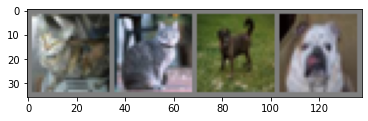

In [115]:
# Run this cell multiple time to see more samples

def imshow(img):
    """ show an image """
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
images, labels = train_data_iter.next()


# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolutional Neural Network

**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully come back and improve the architecture

In [116]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

channels = x.shape[1]
height = x.shape[2]
width = x.shape[3]
num_filters=16
kernel_size_conv1=2
stride_conv1=1
padding_conv1=0
hidden_units=100

class Net(nn.Module):
  
    def compute_conv_dim(self, dim_size):
        return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

    def compute_pool_dim(self, dim_size, kernel, stride):
        return int((dim_size - kernel)/stride+1)

    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.num_classes = num_classes

        self.conv_out_height = self.compute_conv_dim(height)
        self.conv_out_width = self.compute_conv_dim(width)
        
        # self.l1_in_features = num_filters * self.conv_out_height * self.conv_out_width
        # self.l1_in_features = 8 * 30 * 30
        self.l1_in_features = num_filters*self.compute_pool_dim(self.conv_out_height, 2, 2)*self.compute_pool_dim(self.conv_out_height, 2, 2)
        # self.l1_in_features = num_filters * 15*15
        # self.l1_in_features = 4 * 14*14

        self.conv_1 = nn.Conv2d(in_channels=channels,
                             out_channels=num_filters,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1)
        
        self.pool_1 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        self.conv_2 = nn.Conv2d(in_channels=num_filters,
                             out_channels=8,
                             kernel_size=2,
                             stride=1,
                             padding=0)

        # batch norm with 3 channels
        self.batch_norm = nn.BatchNorm2d(num_features=3)

        self.dropout = nn.Dropout2d(p=0.5)

        self.l_1 = nn.Linear(in_features=self.l1_in_features,
                          out_features=hidden_units,
                          bias=True)
        
        self.l_out = nn.Linear(in_features=hidden_units,
                            out_features=num_classes,
                            bias=False)


    def forward(self, x):
      
      x = self.batch_norm(x)
      x = relu(self.conv_1(x))
      # print(x.size())
      # x = self.dropout(x)
      x = self.pool_1(x)
      
      # x = relu(self.conv_2(x))

      # x = x.view(-1, num_filters*self.conv_out_height*self.conv_out_width)
      # x = x.view(-1, num_filters*15*15)
      x = x.view(-1, num_filters*self.compute_pool_dim(self.conv_out_height, 2, 2)*self.compute_pool_dim(self.conv_out_height, 2, 2))
      # x = x.view(-1, 8*30*30)
      
      x = relu(self.l_1(x))
      # x = self.dropout(x)
      

      return softmax(self.l_out(x), dim=1)
    

net = Net(len(used_categories))
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1))
  (pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (batch_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (l_1): Linear(in_features=3600, out_features=100, bias=True)
  (l_out): Linear(in_features=100, out_features=2, bias=False)
)


## 3. Define a Loss function and optimizer

**Assignment 2:** Implement the criterion and optimizer. 
We suggest Classification Cross-Entropy loss and SGD with momentum.
You might need to experiment a bit with the learning rate.

In [117]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

## 4. Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 3).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [118]:
num_epoch = 8  # Your code here!

for epoch in range(num_epoch):  # loop over the dataset multiple times

    net.train()

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #forward
        output = net(inputs)
        # compute loss
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.672
[1,  2000] loss: 0.640
[2,  1000] loss: 0.611
[2,  2000] loss: 0.612
[3,  1000] loss: 0.591
[3,  2000] loss: 0.585
[4,  1000] loss: 0.569
[4,  2000] loss: 0.561
[5,  1000] loss: 0.555
[5,  2000] loss: 0.551
[6,  1000] loss: 0.536
[6,  2000] loss: 0.536
[7,  1000] loss: 0.518
[7,  2000] loss: 0.526
[8,  1000] loss: 0.504
[8,  2000] loss: 0.516
Finished Training


## 5. Test the network on the test data

Now we need to check if the network has learnt anything at all.
We will check this by predicting the class label that the neural network outputs, and checking it against the ground truth.
If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

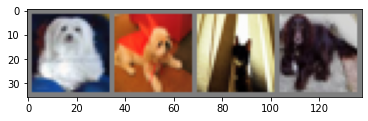

GroundTruth:     dog   dog   cat   dog
Predicted:       dog   dog   dog   cat


In [119]:
images, labels = test_data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
plt.show()

print('GroundTruth:  ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs.data, 1)
print('Predicted:    ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [120]:
correct = 0
total = 0

net.eval()

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
    testset.data.shape[0], 100 * correct.true_divide(total)))

Accuracy of the network on the 2000 test images: 70.10 %


Hopefully the network is better than chance, which is $\frac{1}{\text{number of classes}}$ accuracy (randomly picking
a class).


We can also examine which class the network found the most difficult (makes more sense if you have many clases):

In [121]:
class_total = list(0. for i in range(len(classes)))
class_correct = list(0. for i in range(len(classes)))

for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(len(c)):
        label = labels[i]
        class_correct[label] += c[i].numpy()
        class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of {:5s} : {:5.2f} %'.format(
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of cat   : 76.10 %
Accuracy of dog   : 64.10 %


**Assignment 4:** 
1. Go back and improve performance of the network. 
 * If you are using all 10 classes you should get a test accuracy above 55%, but see how much further you can get it!
 * If you are using only 2 classes (e.g. cat and dog) you should get a test accuracy above 60%, but see how much further you can get it!

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?

3. Write down key lessons/insights you got (if any) during this exercise.

**Answer:**
68%
<br>
Increasing the number of epochs from 3 to 6 reduced the training loss, but there was no difference to the test accuracy.
I tried reducing the filters from 16 to 8 but no difference in test accuracy.
Then, I added a pooling layer with stride of 2 and kernel size of 2. This made the computations significantly faster but gave more or less the same accuracy on the test set (68.85). With the pooling layer, I increased the number of epochs from 3 to 6, resulting in lower training loss but only a slight increase in test accuracy (69.85%). From the previous lab, the batch norm layer had given a slight boost in accuracy so I added a batch normalization layer in this network which increased the accuracy to about 70%.

I also tried with lower and higher learning rates but the default one seems optimal.

From the network above (with 1 conv1, pooling and batch norm) I tried increasing the number of hidden layers from 100 to 200 but to no avail. Then I decided to add dropout before output layer but it decreased the accuracy (69%). I tried changing the p values for the dropout layer and moving it around including after the conv layer but it did not help.
I also added an extra conv layer with kernel size 2, stride 1 and 16 filters did not change performance much.


# Training on GPU

**Optional Assignment:**
If you have a GPU we suggest that you try and rewrite the code above to run on the GPU
___

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU.
This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```
    net.cuda()
```

Remember that you will have to send the inputs and targets at every step to the GPU too:

```
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why dont I notice MASSIVE speedup compared to CPU? 
Because your network is realllly small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

## Setting up GPU in Colab

In Colab, you will get 12 hours of execution time but the session will be disconnected if you are idle for more than 60 minutes. It means that for every 12 hours Disk, RAM, CPU Cache and the Data that is on our allocated virtual machine will get erased.

To enable GPU hardware accelerator, just go to **Runtime -> Change runtime type -> Hardware accelerator -> GPU**

# Michael Nielsen book exercise of own choice

**Assignment 5:** Pick an exercise of own choice from [Michael Nielsens book](http://neuralnetworksanddeeplearning.com/)

**Answer:**
Chapter 3

Show that the cross-entropy is still minimized when $$σ(z)=y$$ When this is the case the cross-entropy has the value:

$$C = -\dfrac{1}{n}\sum_{x}[ylny+(1−y)ln(1−y)]$$

We can take the derivative wrt y to see the behaviour of the function:

$$\dfrac{d}{dy}[yln(y)+(1-y)ln(1-y)]$$
$$1*ln(y)+y(1/y)+(-1(ln(1-y))+(1-y)(\dfrac{1}{1-y}*-1))$$
$$ln(y)+1+(-ln(1-y)+(1-y)(\dfrac{-1}{1-y}))$$
$$=ln(y)-ln(1-y)$$

If we look at the derivative we see that when x=1/2 the cost function is either maximum or minimum. If we look further at values y<1/2 and y>1/2 we notice that in the first case, the derivative becomes negative while in the latter it becomes positive. Thus we can conclude that the cost function is concave-up and thus minimises.